## Libraries

In [142]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

## Loading the model and data

In [143]:
model_lgb = None
X_test = None
final_df = None

# --- Load the Model ---
try:
    model_lgb = joblib.load('lightgbm_model.joblib')
except Exception as e:
    print(f"ERROR loading model_lgb: {e}")

# --- Load X_test ---
try:
    X_test = pd.read_parquet('X_test_model_features.parquet')
except Exception: # Broad exception to catch FileNotFoundError or Parquet read errors
    try:
        X_test = pd.read_csv('X_test_model_features.csv')
    except Exception as e_csv:
        print(f"ERROR loading X_test (tried Parquet and CSV): {e_csv}")

# --- Load final_df ---
try:
    final_df = pd.read_parquet('final_df_for_analysis.parquet')
except Exception: # Broad exception
    try:
        final_df = pd.read_csv('final_df_for_analysis.csv')
        if final_df is not None and 'DateOfReport' in final_df.columns: # Check if df loaded
            final_df['DateOfReport'] = pd.to_datetime(final_df['DateOfReport'], errors='coerce')
    except Exception as e_csv:
        print(f"ERROR loading final_df (tried Parquet and CSV): {e_csv}")

# --- Check if all loaded successfully before proceeding ---
if model_lgb is not None and X_test is not None and final_df is not None:
    # Proceed with your stratification logic using model_lgb, X_test, final_df
    # print("All components loaded successfully.") # Optional: uncomment for a success message
    pass
else:
    print("One or more essential components failed to load. Cannot proceed with analysis.")

In [144]:
# --- Step 1: Configuration for Stratification ---
probability_class_idx_for_strata = 0
strata_config = {
    'labels': ['Lowest_Risk', 'Low_Risk', 'Medium_Risk', 'High_Risk', 'Highest_Risk'],
    'quantiles': [0, 0.40, 0.65, 0.85, 0.97, 1.0]
    }    # Most packages in safe categories
# Dynamically create the names for the new columns
proba_col_name = f'probability_class{probability_class_idx_for_strata}'
stratum_col_name = f'stratum_class{probability_class_idx_for_strata}' # This is THE key variable

# --- Step 2: Function to Assign Strata ---
def assign_strata_from_probabilities(
    trained_model, features_for_prediction, df_to_add_strata_to,
    prob_class_idx, strata_definition, new_proba_col_name, new_stratum_col_name
):
    all_class_probs = trained_model.predict_proba(features_for_prediction)
    selected_probs = all_class_probs[:, prob_class_idx]
    output_df = df_to_add_strata_to.copy()
    output_df[new_proba_col_name] = selected_probs
    try:
        output_df[new_stratum_col_name] = pd.qcut(
            output_df[new_proba_col_name], q=strata_definition['quantiles'],
            labels=strata_definition['labels'], duplicates='drop'
        )
    except Exception:
        output_df[new_stratum_col_name] = np.nan
    return output_df

# --- Step 3: Create the Stratified DataFrame ---
stratified_df = None # Initialize
if ('model_lgb' in locals() and
    'X_test' in locals() and isinstance(X_test, pd.DataFrame) and
    'final_df' in locals() and isinstance(final_df, pd.DataFrame)):

    # Ensure DateOfReport is datetime in final_df if it's going to be used for filtering
    if 'DateOfReport' in final_df.columns and final_df['DateOfReport'].dtype != '<M8[ns]':
         final_df['DateOfReport'] = pd.to_datetime(final_df['DateOfReport'])
    if 'SupplierName' not in final_df.columns: # Basic check
        print("Warning: 'SupplierName' not found in final_df. Supplier filtering will not work.")


    stratified_df = assign_strata_from_probabilities(
        model_lgb, X_test, final_df, probability_class_idx_for_strata,
        strata_config, proba_col_name, stratum_col_name
    )
else:
    print("Initial setup skipped: Required variables (model_lgb, X_test, final_df) not found or not of correct type.")

## Global Functions

In [145]:
def analyze_stratum_distribution(df, title_part=""):
    """
    Calculates and displays the package distribution across risk strata.
    It prints a summary table and shows a bar plot.

    Args:
        df (pd.DataFrame): The DataFrame to analyze (e.g., stratified_df or analysis_df).
        title_part (str): A string to include in titles (e.g., "Overall" or "Date: 2023-08-09").
    """
    if df.empty or stratum_col_name not in df.columns:
        print(f"No package distribution data to display for: {title_part}")
        return

    # --- 1. Calculate the distribution ---
    stratum_counts = df[stratum_col_name].value_counts().reindex(
        strata_config['labels'], fill_value=0
    )

    # --- 2. Display the summary table ---
    distribution_summary_df = pd.DataFrame({
        'Package_Count': stratum_counts,
        'Percentage': (stratum_counts / stratum_counts.sum()) * 100 if stratum_counts.sum() > 0 else 0
    })
    distribution_summary_df.index.name = 'Risk Stratum'

    print(f"--- Package Distribution by Stratum ({title_part}) ---")
    display(distribution_summary_df.style.format({
        'Package_Count': '{:,.0f}', 'Percentage': '{:.2f}%'
    }))

    # --- 3. Visualize the distribution ---
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=distribution_summary_df.index,
        y=distribution_summary_df['Package_Count'],
        palette="viridis"
    )
    plt.title(f'Distribution of Packages by Risk Stratum\n({title_part})')
    plt.xlabel('Risk Stratum')
    plt.ylabel('Number of Packages')
    plt.tight_layout()
    plt.show()



In [146]:
def analyze_actual_vs_predicted(df, title_part=""):
    """
    Aggregates and plots the actual good rate vs. the average predicted probability.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        title_part (str): A string to include in titles.
    """
    required_cols = ['ActualQuality', 'PredictedQualityProba', stratum_col_name]
    if df.empty or not all(col in df.columns for col in required_cols):
        print(f"Skipping Actual vs. Predicted analysis for {title_part}: required columns missing.")
        return

    # --- 1. Aggregate data ---
    summary_df = df.groupby(stratum_col_name).agg(
        Total_Packages=('ActualQuality', 'count'),
        Actual_Good_Rate=('ActualQuality', 'mean'),
        Avg_PredictedQualityProba=('PredictedQualityProba', 'mean')
    ).reindex(strata_config['labels'])

    print(f"\n--- Summary for: {title_part} ---")
    print(summary_df)

    # --- 2. Plot the results ---
    if not summary_df['Actual_Good_Rate'].isnull().all():
        plt.figure(figsize=(10, 6))
        summary_df['Actual_Good_Rate'].plot(kind='bar', color='#3a64f2', alpha=0.85, label='Actual Good Rate')
        summary_df['Avg_PredictedQualityProba'].plot(kind='line', marker='o', color='#e53935', linewidth=2, label='Avg. Predicted Probability')

        plt.title(f'Actual vs. Predicted Quality ({title_part})')
        plt.ylabel('Proportion / Probability')
        plt.xlabel('Risk Stratum')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


In [147]:
def analyze_supplier_risk_profile(df, title_part=""):
    """
    Creates the detailed supplier risk profile summary table.
    (This version fixes the .get() error and silences the FutureWarning)
    """
    required_cols = ['SupplierName', 'ActualQuality', stratum_col_name]
    if df.empty or not all(col in df.columns for col in required_cols):
        print(f"No supplier profile data to display for: {title_part}")
        return

    try:
        # --- 1. Base Statistics ---
        summary = df.groupby('SupplierName', observed=False).agg(
            TotalPackages=('ActualQuality', 'size'),
            Overall_Good_Rate=('ActualQuality', 'mean')
        )

        # --- 2. Stratum Distribution (%) ---
        stratum_dist_pct = (
            df.pivot_table(index='SupplierName', columns=stratum_col_name, aggfunc='size', fill_value=0, observed=False)
              .apply(lambda r: 100 * r / r.sum(), axis=1)
              .rename(columns=lambda c: f'% in {c}')
        )

        # --- 3. Rates in Specific Strata ---
        highest_risk_label, lowest_risk_label = strata_config['labels'][0], strata_config['labels'][-1]
        specific_rates = (
            df.pivot_table(index='SupplierName', columns=stratum_col_name, values='ActualQuality', aggfunc='mean', observed=False)
              [[highest_risk_label, lowest_risk_label]]
              .rename(columns=lambda c: f'Good_Rate_in_{c}')
        )

        # --- 4. Assemble Final Table ---
        final_summary_df = summary.join([stratum_dist_pct, specific_rates], how='left')
        sort_col = f'% in {highest_risk_label}'
        if sort_col in final_summary_df.columns:
            final_summary_df = final_summary_df.sort_values(by=sort_col, ascending=False)

        # --- 5. Display ---
        print(f"--- Supplier Risk Profile ({title_part}) ---")
        percent_cols = [col for col in final_summary_df.columns if '%' in col or 'Rate' in col]
        styled_df = final_summary_df.style.format('{:.2f}%', subset=percent_cols, na_rep='-') \
                                          .format({'TotalPackages': '{:,.0f}'})
        display(styled_df)

    except (KeyError, ZeroDivisionError, Exception) as e:
        print(f"Could not generate supplier profile for {title_part}. Error: {e}")


In [148]:
def analyze_supplier_composition_chart(df, title_part=""):
    """
    Generates a stacked bar chart showing the percentage composition of suppliers
    within each risk stratum.
    """
    if df.empty or 'SupplierName' not in df.columns:
        print(f"No supplier data to plot for the selected filter ({title_part}).")
        return

    try:
        # --- Data Preparation ---
        supplier_dist_df = (
            df.pivot_table(
                index=stratum_col_name,
                columns='SupplierName',
                aggfunc='size',
                fill_value=0,
                observed=False
            )
            .apply(lambda row: 100 * row / row.sum() if row.sum() > 0 else row, axis=1)
            .reindex(strata_config['labels'])
            .fillna(0)
        )
    except (KeyError, ZeroDivisionError, Exception) as e:
        print(f"Could not generate supplier composition chart for {title_part}. Error: {e}")
        return

    # --- Visualization ---
    if not supplier_dist_df.empty and supplier_dist_df.sum().sum() > 0:
        num_suppliers = supplier_dist_df.shape[1]
        
        colors = ['#3a64f2', '#1f4e79', '#e53935', '#43a047', '#ff9800', 
                  '#8e24aa', '#00acc1', '#ff5722', '#795548', '#607d8b',
                  '#4caf50', '#2196f3', '#f44336', '#ffeb3b', '#9c27b0']
        
        if num_suppliers > len(colors):
            import matplotlib.cm as cm
            colors = cm.get_cmap('tab20', num_suppliers).colors

        fig, ax = plt.subplots(figsize=(14, 8))
        supplier_dist_df.plot(kind='bar', stacked=True, ax=ax, color=colors[:num_suppliers], width=0.75)

        ax.set_title(f'Supplier Composition within Each Risk Stratum\n({title_part})', fontsize=16, pad=20)
        ax.set_xlabel('Risk Stratum', fontsize=12)
        ax.set_ylabel('Percentage of Packages (%)', fontsize=12)
        ax.tick_params(axis='x', rotation=0, labelsize=11)
        ax.legend(title='Supplier Name', bbox_to_anchor=(1.02, 1), loc='upper left')

        for container in ax.containers:
            labels = [f'{h:.1f}%' if h > 5 else '' for h in container.datavalues]
            ax.bar_label(container, labels=labels, label_type='center', fontsize=9, color='white', fontweight='bold')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()
    else:
        print(f"No supplier data to plot for the selected filter ({title_part}).")

In [149]:
def analyze_weight_by_stratum(df, title_part=""):
    """
    Analyzes package weight across risk strata with a harmonized color scheme.
    """
    if df.empty or 'Weight' not in df.columns:
        print(f"Skipping Weight Analysis for {title_part}: 'Weight' column missing.")
        return

    # --- 1. Average Weight Bar Plot ---
    avg_weight_summary = df.groupby(stratum_col_name, observed=False)['Weight'].mean()
    print(f"--- Average Package Weight per Stratum ({title_part}) ---")
    print(avg_weight_summary)

    plt.figure(figsize=(10, 5))
    avg_weight_summary.plot(kind='bar', color='#3a64f2', alpha=0.8)
    plt.title(f'Average Package Weight per Risk Stratum\n({title_part})')
    plt.xlabel('Risk Stratum')
    plt.ylabel('Average Weight')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- 2. Weight Distribution Box Plot ---
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df, x=stratum_col_name, y='Weight', order=strata_config['labels'], palette='viridis')
    plt.title(f'Distribution of Package Weights by Risk Stratum\n({title_part})')
    plt.xlabel('Risk Stratum')
    plt.ylabel('Package Weight')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [150]:
def analyze_garment_type_risk_distribution(df, title_part="", top_n=10):
    """
    Analyzes how each garment type is distributed across the risk strata.
    Displays a horizontal stacked bar chart for the top N garment types by count.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        title_part (str): A string to include in titles.
        top_n (int): The number of top garment types to display.
    """
    if df.empty or 'GarmentType' not in df.columns:
        print(f"Skipping Garment Type Analysis for {title_part}: 'GarmentType' column missing.")
        return

    try:
        # --- 1. Data Preparation ---
        # Get the top N garment types by total count in the current dataset
        top_garments = df['GarmentType'].value_counts().nlargest(top_n).index

        # Pivot to get the distribution of ONLY these top garments
        garment_dist_df = (
            df[df['GarmentType'].isin(top_garments)]
            .pivot_table(
                index='GarmentType',
                columns=stratum_col_name,
                aggfunc='size',
                fill_value=0,
                observed=False
            )
            # Order columns by risk and rows by total count
            .reindex(columns=strata_config['labels'])
            .loc[top_garments]
        )
        
        # Normalize to get percentages
        garment_dist_pct = garment_dist_df.apply(
            lambda r: 100 * r / r.sum() if r.sum() > 0 else r, axis=1
        )

    except (KeyError, ZeroDivisionError, Exception) as e:
        print(f"Could not generate Garment Type analysis for {title_part}. Error: {e}")
        return
    # --- 2. Visualization ---
    if not garment_dist_pct.empty:
        print(f"--- Risk Distribution for Top {top_n} Garment Types ({title_part}) ---")
        
        plot_height = max(6, len(garment_dist_pct) * 0.6)
        garment_dist_pct.plot(
            kind='barh',
            stacked=True,
            figsize=(12, plot_height),
            colormap='viridis_r'
        )
        
        plt.title(f'Risk Distribution of Top {top_n} Garment Types\n({title_part})')
        plt.xlabel('Percentage of Packages (%)')
        plt.ylabel('Garment Type')
        plt.legend(title='Risk Stratum', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.gca().invert_yaxis()
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

## EDA

### Historical

--- Package Distribution by Stratum (Overall) ---


,Package_Count,Percentage
Risk Stratum,,
Lowest_Risk,"56,871",40.00%
Low_Risk,"35,544",25.00%
Medium_Risk,"28,435",20.00%
High_Risk,"17,061",12.00%
Highest_Risk,"4,266",3.00%


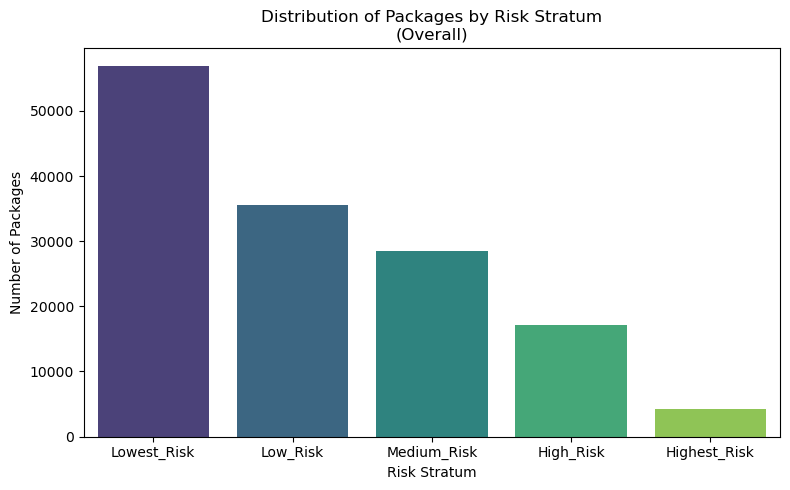

In [151]:
# Analyze the Stratified DataFrame 
analyze_stratum_distribution(stratified_df, title_part="Overall")


--- Summary for: Overall ---
                Total_Packages  Actual_Good_Rate  Avg_PredictedQualityProba
stratum_class0                                                             
Lowest_Risk              56871          0.908178                   0.740599
Low_Risk                 35544          0.804158                   0.519268
Medium_Risk              28435          0.714823                   0.395443
High_Risk                17061          0.649083                   0.310882
Highest_Risk              4266          0.572902                   0.225835


/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_6957/2494533875.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = df.groupby(stratum_col_name).agg(


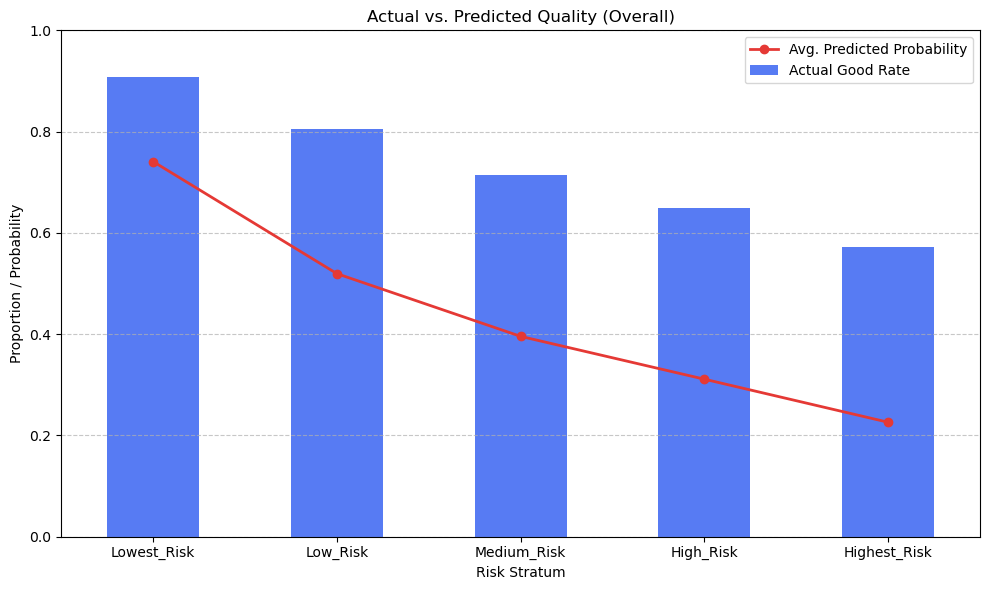

In [152]:
# Analyze the actual vs predicted quality
analyze_actual_vs_predicted(stratified_df, title_part="Overall")

In [153]:
# Analyze supplier risk profile
analyze_supplier_risk_profile(stratified_df, title_part="Overall")

--- Supplier Risk Profile (Overall) ---


,TotalPackages,Overall_Good_Rate,% in Lowest_Risk,% in Low_Risk,% in Medium_Risk,% in High_Risk,% in Highest_Risk,Good_Rate_in_Lowest_Risk,Good_Rate_in_Highest_Risk
SupplierName,,,,,,,,,
SupplierA,"40,410",0.917867,82.754269,16.085127,1.054195,0.098985,0.007424,0.934093,1.000000
SupplierB,"31,923",0.849857,66.666667,28.672117,4.028443,0.617110,0.015663,0.874166,0.600000
SupplierG,"7,356",0.827896,26.291463,59.651985,12.520392,1.454595,0.081566,0.847983,0.833333
SupplierE,"11,477",0.771630,1.219831,73.782347,20.449595,4.347826,0.200401,0.814286,0.565217
SupplierC,"21,534",0.726433,0.292561,30.180180,50.919476,17.163555,1.444228,0.777778,0.652733
SupplierF,"9,904",0.638328,0.050485,1.120759,17.104200,62.641357,19.083199,0.600000,0.586243
SupplierD,"15,183",0.678785,0.032932,2.272278,67.015741,25.370480,5.308569,0.400000,0.593052
SupplierH,"4,390",0.600911,0.022779,1.822323,14.145786,56.173121,27.835991,0.000000,0.516367


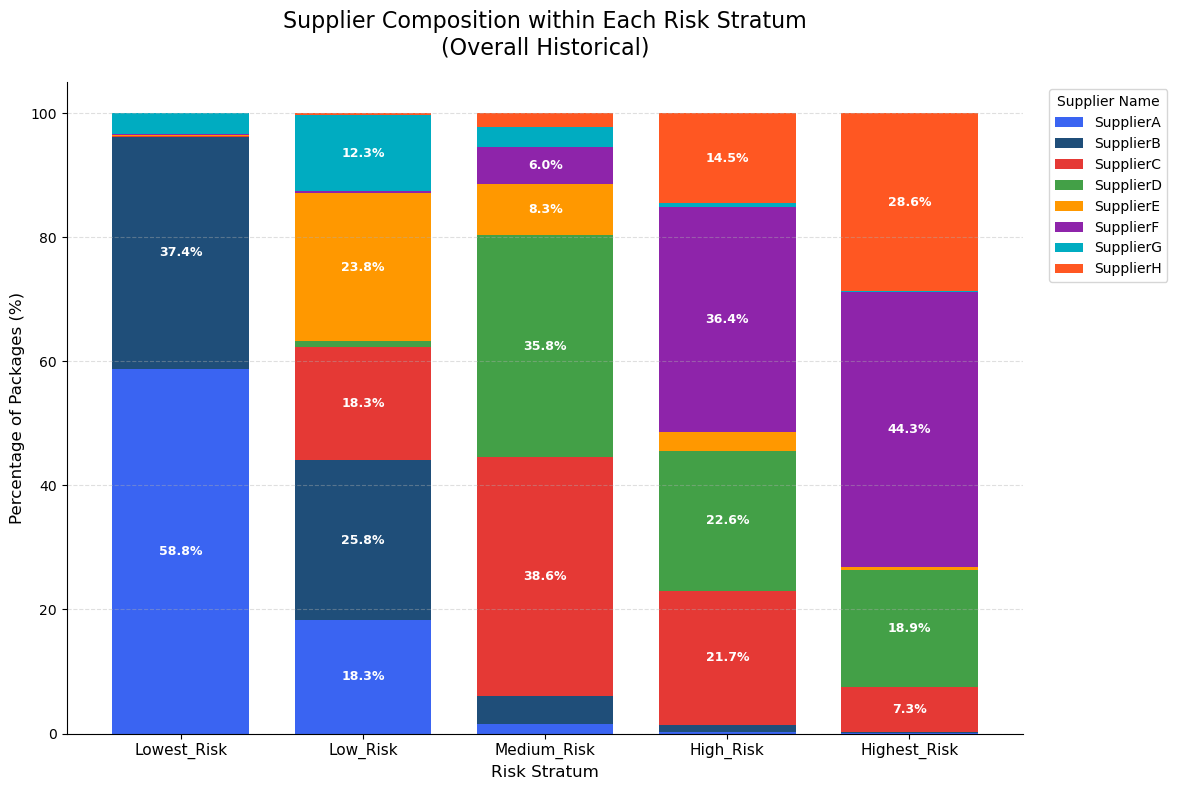

In [154]:
# Analyze supplier composition across all strata
analyze_supplier_composition_chart(stratified_df, title_part="Overall Historical")

--- Average Package Weight per Stratum (Overall Historical) ---
stratum_class0
Lowest_Risk     0.413787
Low_Risk        0.478651
Medium_Risk     0.458075
High_Risk       0.518825
Highest_Risk    0.718202
Name: Weight, dtype: float64


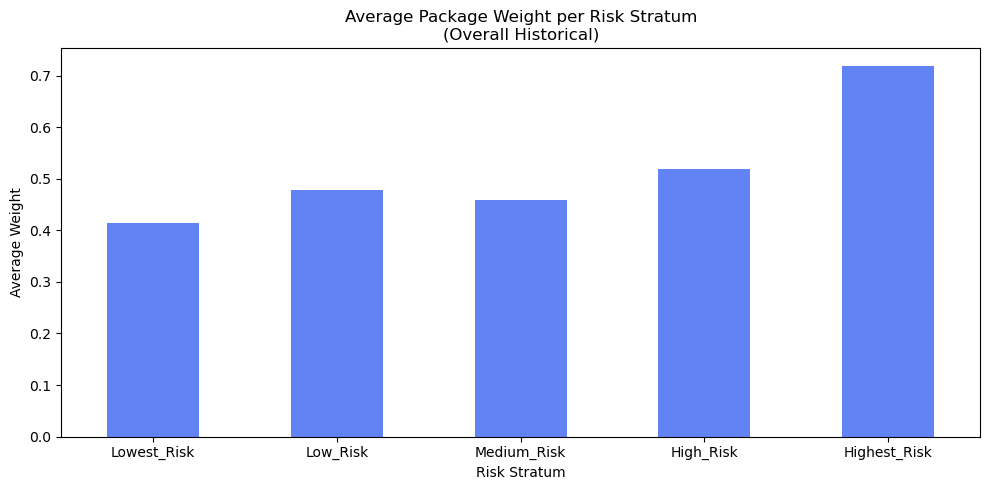

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


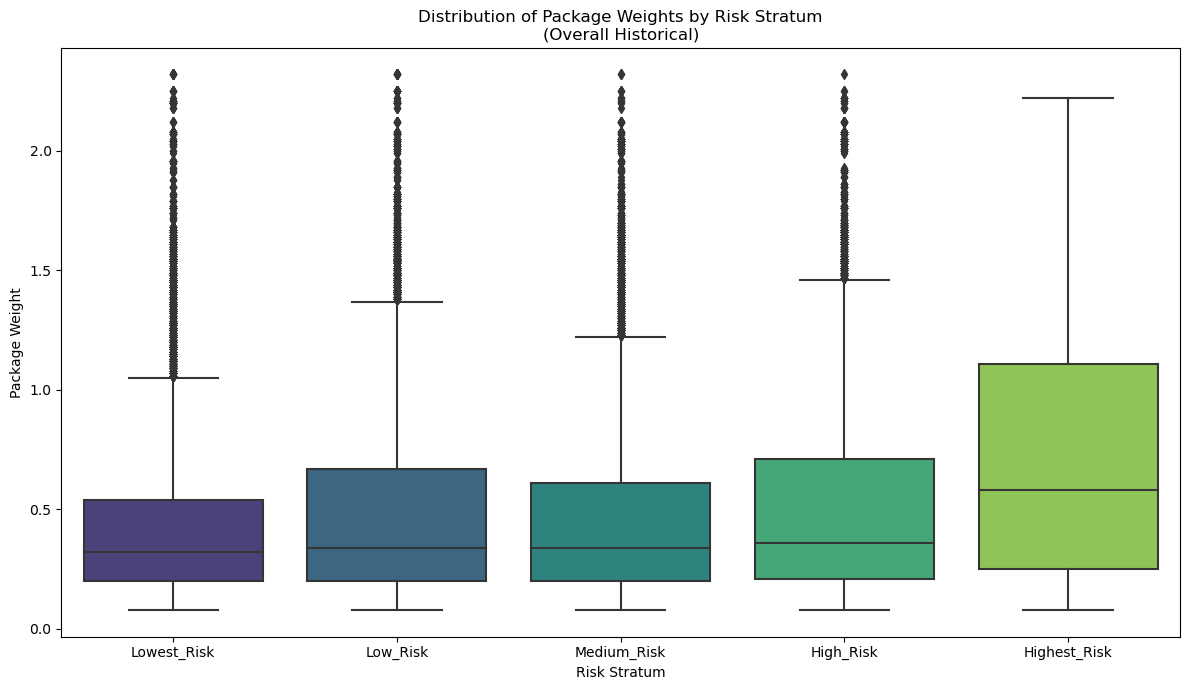

In [155]:
# Analyze package weight by stratum
analyze_weight_by_stratum(stratified_df, "Overall Historical")

--- Risk Distribution for Top 10 Garment Types (Overall Historical) ---


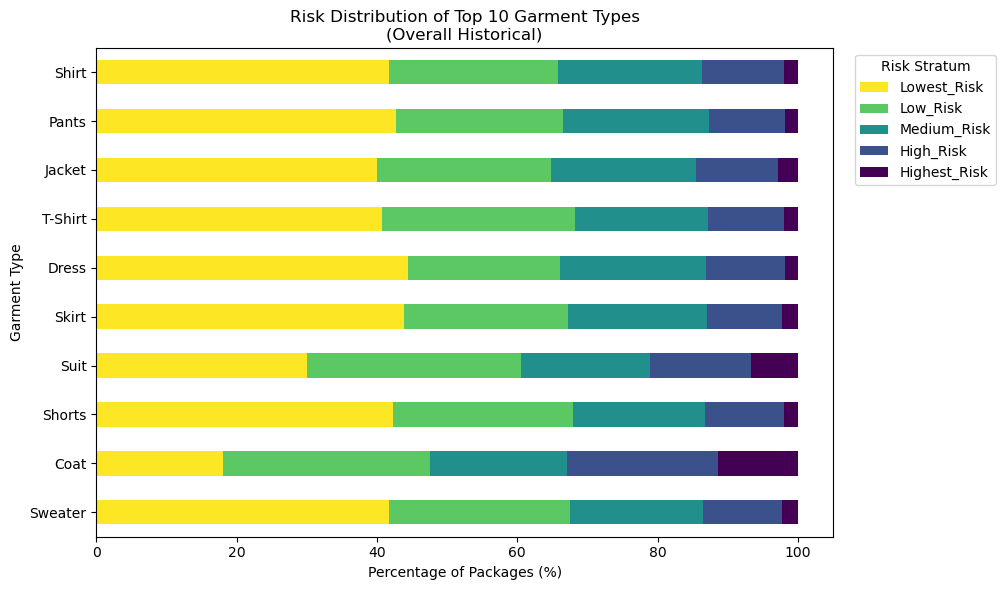

In [156]:
# Analyze garment type risk distribution
analyze_garment_type_risk_distribution(stratified_df, "Overall Historical")

### Filter Specific

In [ ]:
# --- Date Filtering ---
# INSTRUCTIONS: Use ONLY ONE of the three date options. Set others to None.

# Option 1: Custom Date Range 
filter_start_date = '2023-08-09'  # Format: 'YYYY-MM-DD' or None
filter_end_date = '2023-08-12'    # Format: 'YYYY-MM-DD' or None

# Option 2: Single Day 
filter_by_date = None             # Format: 'YYYY-MM-DD' or None

# Option 3: Full Week/Month 
filter_by_week = None             # Format: 'YYYY-MM-DD' (any date in the week) or None
filter_by_month = None            # Format: 'YYYY-MM' or None


# --- Supplier Filtering ---
# Use a list of strings, or None to include all suppliers.
filter_by_suppliers = ['SupplierA', 'SupplierC'] # e.g., ['SupplierA', 'SupplierC'] or None

In [158]:
analysis_df = stratified_df.copy()
filter_parts = [] # We'll build the title dynamically

# --- 1. Date Filtering Logic ---
# Prioritize the custom date range if it's set
if filter_start_date and filter_end_date:
    start = pd.to_datetime(filter_start_date)
    end = pd.to_datetime(filter_end_date)
    analysis_df = analysis_df[
        (analysis_df['DateOfReport'].dt.date >= start.date()) &
        (analysis_df['DateOfReport'].dt.date <= end.date())
    ]
    filter_parts.append(f"Range: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

elif filter_by_date:
    date_obj = pd.to_datetime(filter_by_date)
    analysis_df = analysis_df[analysis_df['DateOfReport'].dt.date == date_obj.date()]
    filter_parts.append(f"Date: {date_obj.strftime('%Y-%m-%d')}")

elif filter_by_week:
    week_obj = pd.to_datetime(filter_by_week)
    year, week_num, _ = week_obj.isocalendar()
    analysis_df = analysis_df[
        (analysis_df['DateOfReport'].dt.isocalendar().year == year) &
        (analysis_df['DateOfReport'].dt.isocalendar().week == week_num)
    ]
    filter_parts.append(f"Week: {year}-W{week_num}")

elif filter_by_month:
    analysis_df = analysis_df[analysis_df['DateOfReport'].dt.strftime('%Y-%m') == filter_by_month]
    filter_parts.append(f"Month: {filter_by_month}")


# --- 2. Supplier Filtering Logic ---
# This runs *after* the date filter, on the already-filtered data
if filter_by_suppliers and 'SupplierName' in analysis_df.columns:
    # .isin() is the correct method for filtering by a list
    analysis_df = analysis_df[analysis_df['SupplierName'].isin(filter_by_suppliers)]
    # Use join to handle multiple supplier names cleanly
    filter_parts.append(f"Suppliers: {', '.join(filter_by_suppliers)}")


# --- 3. Finalize Title and Print Summary ---
if not filter_parts:
    filter_title_part = "Overall Historical"
else:
    filter_title_part = " & ".join(filter_parts)

print(f"Analysis will run on {len(analysis_df)} records for filter: {filter_title_part}")

Analysis will run on 974 records for filter: Range: 2023-08-09 to 2023-08-12


--- Package Distribution by Stratum (Range: 2023-08-09 to 2023-08-12) ---


,Package_Count,Percentage
Risk Stratum,,
Lowest_Risk,415,42.61%
Low_Risk,211,21.66%
Medium_Risk,198,20.33%
High_Risk,120,12.32%
Highest_Risk,30,3.08%


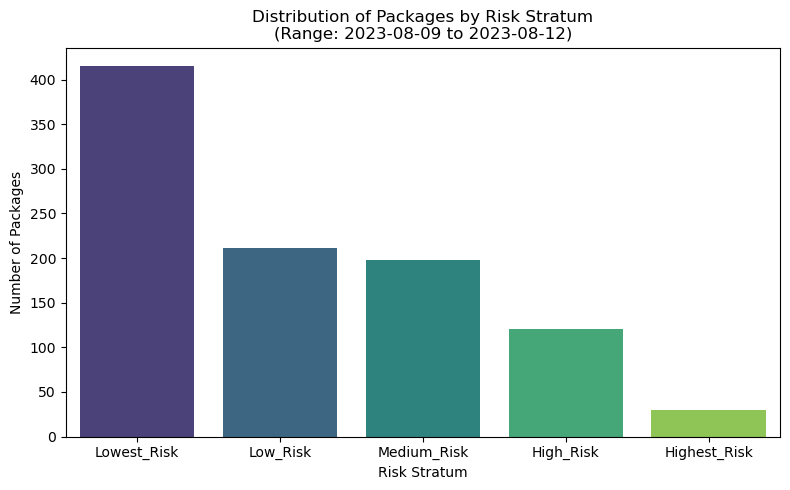

In [159]:
# Analyze the filtered DataFrame per the specified filter
analyze_stratum_distribution(analysis_df, title_part=filter_title_part)


--- Summary for: Range: 2023-08-09 to 2023-08-12 ---
                Total_Packages  Actual_Good_Rate  Avg_PredictedQualityProba
stratum_class0                                                             
Lowest_Risk                415          0.906024                   0.743772
Low_Risk                   211          0.796209                   0.515502
Medium_Risk                198          0.712121                   0.391989
High_Risk                  120          0.741667                   0.308805
Highest_Risk                30          0.500000                   0.232864


/var/folders/fh/z6pvq_495gd075z979mzth4r0000gn/T/ipykernel_6957/2494533875.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = df.groupby(stratum_col_name).agg(


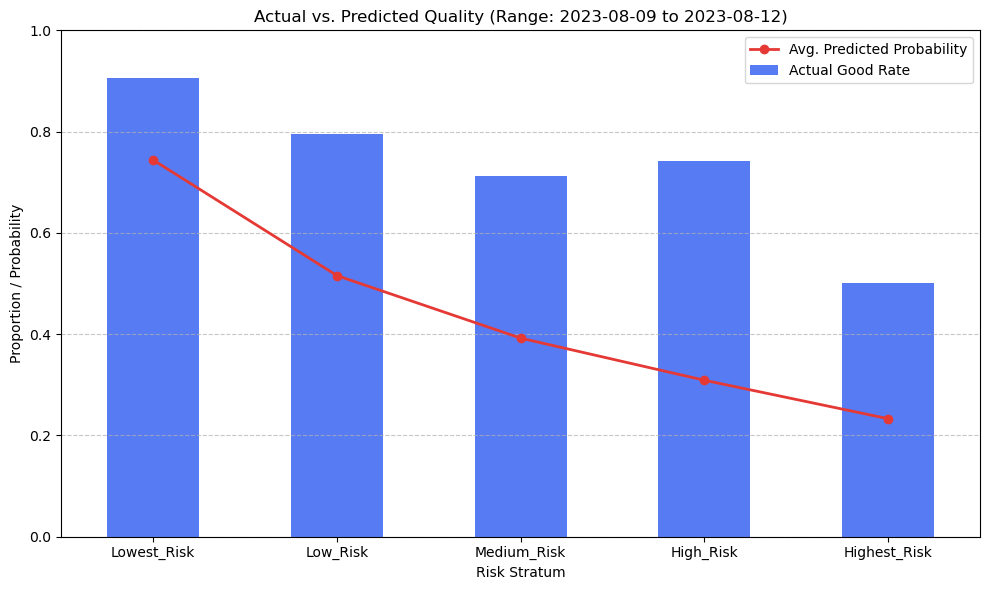

In [160]:
# Analyze the actual vs predicted quality for the filtered DataFrame
analyze_actual_vs_predicted(analysis_df, title_part=filter_title_part)

In [161]:
# Analyze the supplier risk profile for the filtered DataFrame
analyze_supplier_risk_profile(analysis_df, title_part=filter_title_part)

--- Supplier Risk Profile (Range: 2023-08-09 to 2023-08-12) ---


,TotalPackages,Overall_Good_Rate,% in Lowest_Risk,% in Low_Risk,% in Medium_Risk,% in High_Risk,% in Highest_Risk,Good_Rate_in_Lowest_Risk,Good_Rate_in_Highest_Risk
SupplierName,,,,,,,,,
SupplierA,280,0.928571,89.642857,10.000000,0.357143,0.000000,0.000000,0.932271,nan
SupplierB,201,0.850746,64.676617,30.348259,4.975124,0.000000,0.000000,0.869231,nan
SupplierG,49,0.816327,57.142857,36.734694,6.122449,0.000000,0.000000,0.857143,nan
SupplierE,70,0.771429,5.714286,67.142857,27.142857,0.000000,0.000000,0.750000,nan
SupplierC,151,0.715232,1.324503,35.761589,40.397351,19.205298,3.311258,1.000000,0.600000
SupplierD,116,0.681034,0.000000,2.586207,77.586207,17.241379,2.586207,nan,0.000000
SupplierF,77,0.740260,0.000000,0.000000,10.389610,70.129870,19.480519,nan,0.533333
SupplierH,30,0.666667,0.000000,0.000000,20.000000,56.666667,23.333333,nan,0.571429


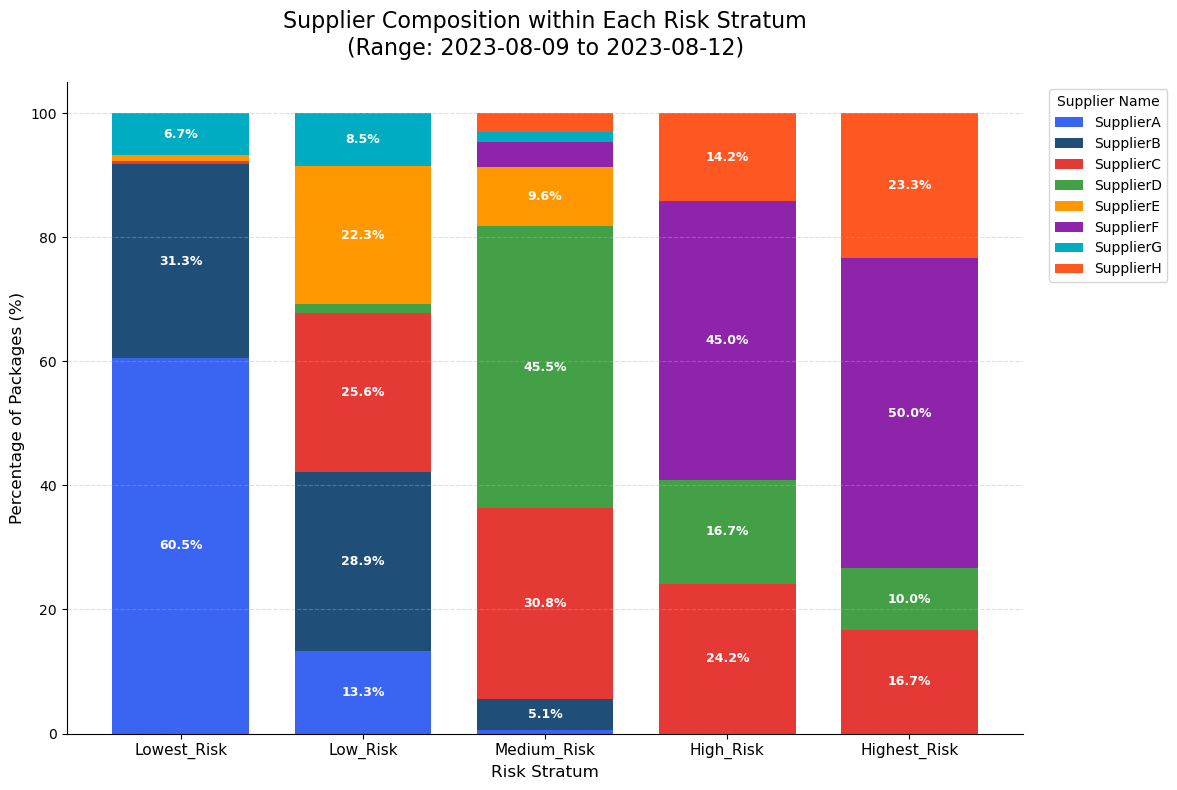

In [162]:
# Analyze the supplier composition across all strata for the filtered DataFrame
analyze_supplier_composition_chart(analysis_df, title_part=filter_title_part)

--- Average Package Weight per Stratum (Range: 2023-08-09 to 2023-08-12) ---
stratum_class0
Lowest_Risk     0.413687
Low_Risk        0.474645
Medium_Risk     0.418788
High_Risk       0.521917
Highest_Risk    0.751333
Name: Weight, dtype: float64


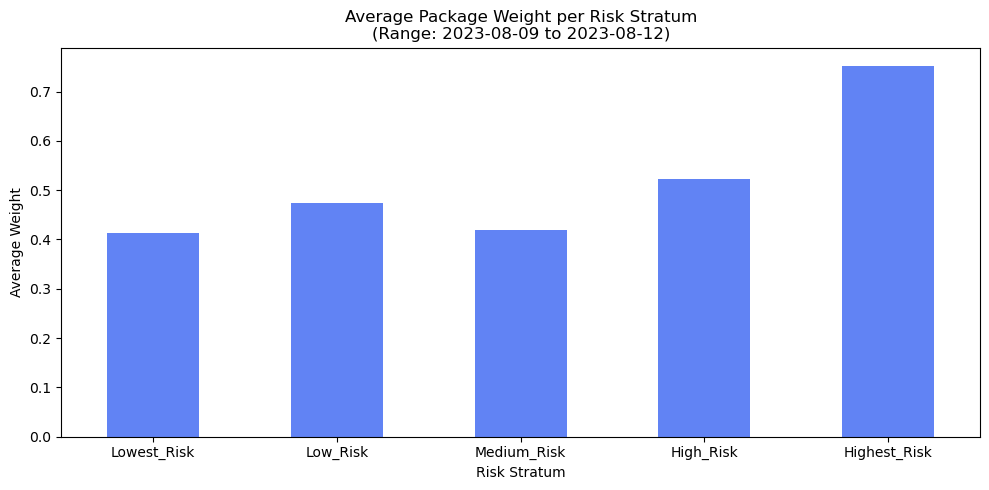

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


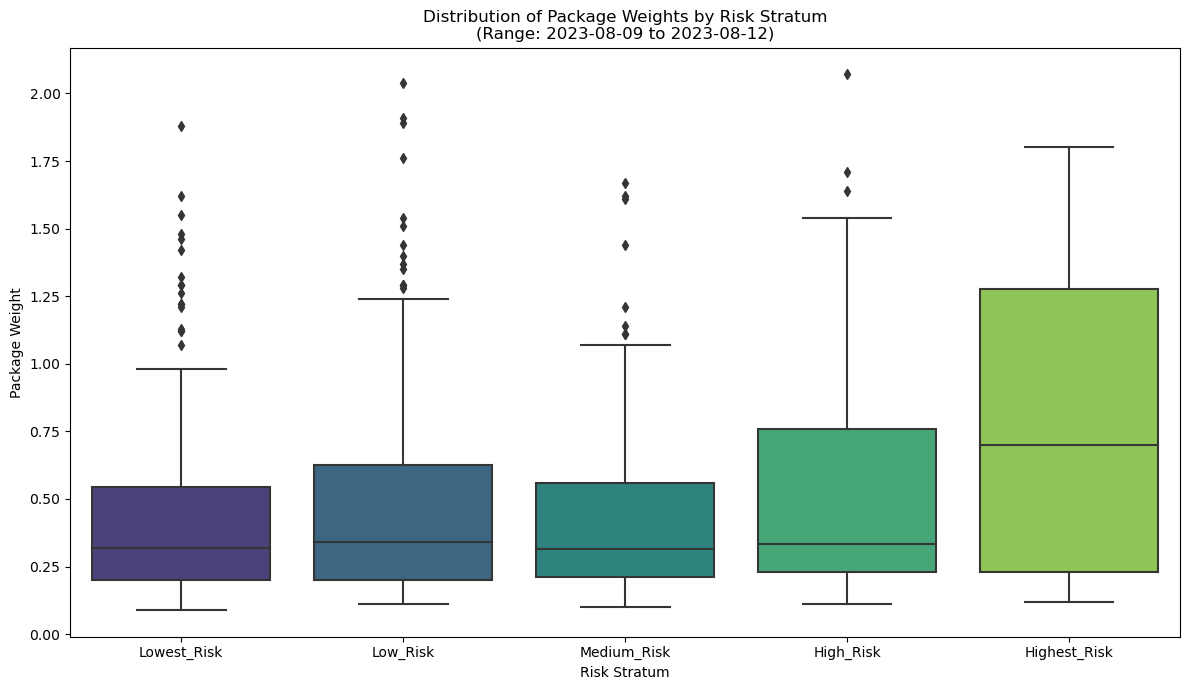

In [163]:
# Analyze package weight by stratum for the filtered DataFrame
analyze_weight_by_stratum(analysis_df, filter_title_part)

--- Risk Distribution for Top 10 Garment Types (Range: 2023-08-09 to 2023-08-12) ---


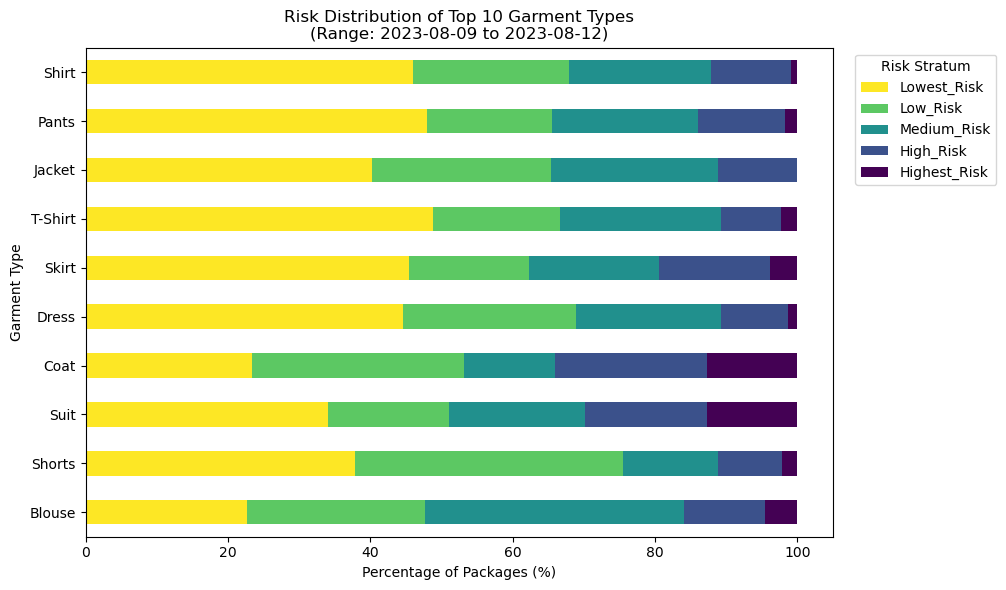

In [164]:
# Analyze garment type risk distribution for the filtered DataFrame
analyze_garment_type_risk_distribution(analysis_df, filter_title_part)